In [1]:
!pip install pycocoevalcap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 9.7 MB/s eta 0:00:00


In [2]:

import os
import random
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from pycocoevalcap.bleu.bleu import Bleu
from pycocoevalcap.meteor.meteor import Meteor
from pycocoevalcap.rouge.rouge import Rouge
from pycocoevalcap.cider.cider import Cider
from torchvision import models, transforms
from tqdm import tqdm
from datasets import load_dataset
from typing import List
from collections import Counter
import math
import re

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [3]:
def basic_tokenize(text: str) -> List[str]:
    text = text.lower().strip()
    text = re.sub(r'([.,!?;:()])', r' \1 ', text)
    text = re.sub(r'\s+', ' ', text)
    return text.split()

class SimpleTokenizer:
    def __init__(self, vocab: List[str]):
        specials = ["<pad>", "<bos>", "<eos>", "<unk>"]
        vocab = specials + [w for w in vocab if w not in specials]
        self.stoi = {w: i for i, w in enumerate(vocab)}
        self.itos = {i: w for w, i in self.stoi.items()}
        self.pad_id = self.stoi["<pad>"]
        self.bos_id = self.stoi["<bos>"]
        self.eos_id = self.stoi["<eos>"]
        self.unk_id = self.stoi["<unk>"]

    def encode(self, text: str) -> List[int]:
        tokens = basic_tokenize(text)
        return [self.stoi.get(t, self.unk_id) for t in tokens]

    def decode(self, ids: List[int]) -> str:
        toks = []
        for i in ids:
            if i in (self.pad_id, self.bos_id, self.eos_id):
                continue
            toks.append(self.itos.get(i, "<unk>"))
        sent = " ".join(toks)
        sent = re.sub(r'\s+([.,!?;:])', r'\1', sent)
        return sent

def collect_rsicd_words(hf_train, hf_val, min_freq=3):
    cnt = Counter()
    for split in [hf_train, hf_val]:
        for ex in split:
            cap = ex["captions"]
            if isinstance(cap, list):
                for c in cap:
                    cnt.update(basic_tokenize(c))
            else:
                cnt.update(basic_tokenize(cap))
    words = [w for w, freq in cnt.most_common() if freq >= min_freq]
    return words

ds = load_dataset("arampacha/rsicd")
rsicd_words = collect_rsicd_words(ds["train"], ds["valid"], min_freq=2)
print(f"RSICD unique words (freq >=2): {len(rsicd_words)}")

tokenizer = SimpleTokenizer(rsicd_words)
print(f"Final vocab size: {len(tokenizer.stoi)}")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


dataset_infos.json: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/419M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/55.1M [00:00<?, ?B/s]

data/valid-00000-of-00001.parquet:   0%|          | 0.00/51.6M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8734 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1093 [00:00<?, ? examples/s]

Generating valid split:   0%|          | 0/1094 [00:00<?, ? examples/s]

RSICD unique words (freq >=2): 2028
Final vocab size: 2032


In [4]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(0.1, 0.1, 0.1, 0.05),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

In [5]:
class RSICDDataset(Dataset):
    def __init__(self, hf_split, tokenizer, transform=None, max_len=25, is_train=True, n_caps=5):
        self.data = hf_split
        self.tokenizer = tokenizer
        self.transform = transform
        self.max_len = max_len
        self.is_train = is_train
        self.n_caps = n_caps

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        ex = self.data[idx]

        # image
        img_path = ex.get("image_path", ex.get("image"))
        if isinstance(img_path, str):
            image = Image.open(img_path).convert("RGB")
        else:
            image = ex["image"]
            if not isinstance(image, Image.Image):
                image = Image.fromarray(np.array(image))
        if self.transform is not None:
            image = self.transform(image)

        caps = ex["captions"]
        if isinstance(caps, str):
            caps = [caps]
        caps = [c.strip() for c in caps if isinstance(c, str) and c.strip()]
        caps = caps[:self.n_caps]
        assert len(caps) == self.n_caps

        return image, caps


def collate_fn(batch):
    images_expanded = []
    captions_ids = []
    all_caps_batch = []

    for image, caps in batch:
        all_caps_batch.append(caps)

        for c in caps:
            images_expanded.append(image)

            ids = tokenizer.encode(c)
            ids = [tokenizer.bos_id] + ids + [tokenizer.eos_id]
            ids = ids[:max_len]
            pad_len = max_len - len(ids)
            if pad_len > 0:
                ids = ids + [tokenizer.pad_id] * pad_len
            captions_ids.append(torch.tensor(ids, dtype=torch.long))

    images_expanded = torch.stack(images_expanded, dim=0)
    captions_ids = torch.stack(captions_ids, dim=0)
    return images_expanded, captions_ids, all_caps_batch


In [6]:
batch_size = 64
max_len = 25
n_caps = 5

train_data = RSICDDataset(ds["train"], tokenizer, transform=train_transform,
                          max_len=max_len, is_train=True, n_caps=n_caps)
val_data   = RSICDDataset(ds["valid"], tokenizer, transform=val_transform,
                          max_len=max_len, is_train=False, n_caps=n_caps)
test_data  = RSICDDataset(ds["test"],  tokenizer, transform=val_transform,
                          max_len=max_len, is_train=False, n_caps=n_caps)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True,
                          num_workers=2, pin_memory=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_data,   batch_size=batch_size, shuffle=False,
                          num_workers=2, pin_memory=True, collate_fn=collate_fn)
test_loader  = DataLoader(test_data,  batch_size=batch_size, shuffle=False,
                          num_workers=2, pin_memory=True, collate_fn=collate_fn)

print(f"Train: {len(train_data)}, Val: {len(val_data)}, Test: {len(test_data)}")


Train: 8734, Val: 1094, Test: 1093


In [ ]:
class ResNetEncoder(nn.Module):
    def __init__(self, output_dim=512, dropout_p=0.5):
        super().__init__()
        base_model = models.resnet101(weights=models.ResNet101_Weights.IMAGENET1K_V2)

        for param in list(base_model.parameters())[:-30]:
            param.requires_grad = False

        modules = list(base_model.children())[:-1]
        self.cnn = nn.Sequential(*modules)
        in_features = base_model.fc.in_features

        self.fc = nn.Linear(in_features, output_dim)
        self.bn = nn.BatchNorm1d(output_dim)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, x):
        with torch.set_grad_enabled(self.training):
            feats = self.cnn(x)
        feats = feats.view(feats.size(0), -1)
        emb = self.fc(feats)
        emb = self.bn(emb)
        emb = self.dropout(emb)
        return emb

class LSTMDecoder(nn.Module):
    def __init__(self, vocab_size, embed_dim=512, hidden_dim=512, num_layers=1, dropout_p=0.5):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim

        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.dropout_embed = nn.Dropout(dropout_p)

        self.lstm = nn.LSTM(
            embed_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout_p if num_layers > 1 else 0
        )

        self.dropout = nn.Dropout(dropout_p)
        self.fc = nn.Linear(hidden_dim, vocab_size)

        self.embed.weight.data.uniform_(-0.1, 0.1)
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-0.1, 0.1)

    def forward(self, img_emb, caption_ids):

        B, T = caption_ids.size()

        h0 = img_emb.unsqueeze(0).repeat(self.num_layers, 1, 1)
        c0 = torch.zeros_like(h0)

        embeddings = self.embed(caption_ids)
        embeddings = self.dropout_embed(embeddings)

        outputs, _ = self.lstm(embeddings, (h0, c0))
        outputs = self.dropout(outputs)

        logits = self.fc(outputs)

        return logits

In [ ]:
class ImageCaptioningModel(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, images, caption_ids):
        img_emb = self.encoder(images)
        logits = self.decoder(img_emb, caption_ids[:, :-1])  # teacher forcing
        return logits

    def generate_caption(self, image, start_token_id, end_token_id, max_len=25, beam_size=5):
        self.eval()
        device = image.device

        with torch.no_grad():
            img_emb = self.encoder(image)

            beams = [([start_token_id], 0.0)]
            completed = []

            for step in range(max_len):
                candidates = []

                for seq, score in beams:
                    if seq[-1] == end_token_id:
                        completed.append((seq, score))
                        continue

                    seq_tensor = torch.tensor([seq], dtype=torch.long, device=device)
                    logits = self.decoder(img_emb, seq_tensor)  # (1, len(seq), vocab_size)
                    log_probs = F.log_softmax(logits[:, -1, :], dim=-1)  # (1, vocab_size)

                    topk_log_probs, topk_ids = torch.topk(log_probs, beam_size)

                    for i in range(beam_size):
                        token_id = topk_ids[0, i].item()
                        token_score = topk_log_probs[0, i].item()
                        new_seq = seq + [token_id]
                        new_score = score + token_score
                        candidates.append((new_seq, new_score))

                candidates.sort(key=lambda x: x[1], reverse=True)
                beams = candidates[:beam_size]

                if not beams:
                    break

            if not completed:
                completed = beams

            completed.sort(key=lambda x: x[1] / len(x[0]), reverse=True)
            best_seq = completed[0][0]

            return best_seq


In [9]:
vocab_size = len(tokenizer.stoi)
embed_dim = 512
hidden_dim = 512

encoder = ResNetEncoder(output_dim=hidden_dim, dropout_p=0.5)
decoder = LSTMDecoder(vocab_size, embed_dim, hidden_dim, num_layers=2, dropout_p=0.5)
model = ImageCaptioningModel(encoder, decoder).to(device)

print(f"Model parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_id)

optimizer = torch.optim.AdamW([
    {'params': encoder.parameters(), 'lr': 1e-5},
    {'params': decoder.parameters(), 'lr': 5e-4}
], weight_decay=1e-4)

num_epochs = 30
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=num_epochs,
    eta_min=1e-6
)


Downloading: "https://download.pytorch.org/models/resnet101-cd907fc2.pth" to /root/.cache/torch/hub/checkpoints/resnet101-cd907fc2.pth


100%|██████████| 171M/171M [00:00<00:00, 198MB/s]


Model parameters: 21,775,344


In [ ]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0

    for images, caption_ids, _ in tqdm(loader, desc="Train", leave=False):
        images = images.to(device)
        caption_ids = caption_ids.to(device)

        logits = model(images, caption_ids)
        target = caption_ids[:, 1:]

        loss = criterion(logits.reshape(-1, vocab_size), target.reshape(-1))

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)


def evaluate(model, loader, tokenizer, device, max_samples=None):
    model.eval()
    total_loss = 0.0
    refs = {}
    hyps = {}
    idx = 0

    with torch.no_grad():
        for images, caption_ids, all_caps_batch in tqdm(loader, desc="Eval", leave=False):
            images = images.to(device)
            caption_ids = caption_ids.to(device)

            logits = model(images, caption_ids)
            target = caption_ids[:, 1:]
            loss = criterion(logits.reshape(-1, vocab_size), target.reshape(-1))
            total_loss += loss.item()

            B = len(all_caps_batch)
            for j in range(B):
                if max_samples and idx >= max_samples:
                    break

                img = images[j * n_caps].unsqueeze(0)

                token_ids = model.generate_caption(
                    img,
                    tokenizer.bos_id,
                    tokenizer.eos_id,
                    max_len=25,
                    beam_size=5
                )
                hyp = tokenizer.decode(token_ids)

                refs[idx] = all_caps_batch[j]
                hyps[idx] = [hyp]
                idx += 1

            if max_samples and idx >= max_samples:
                break

    avg_loss = total_loss / len(loader)

    bleu_scorer = Bleu(4)
    bleu_scores, _ = bleu_scorer.compute_score(refs, hyps)

    cider_scorer = Cider()
    cider_score, _ = cider_scorer.compute_score(refs, hyps)

    return avg_loss, bleu_scores[3], cider_score
def test_evaluation(model, loader, tokenizer, device):
    model.eval()
    total_loss = 0.0
    refs = {}
    hyps = {}
    idx = 0

    print("Generating captions for test set...")
    with torch.no_grad():
        for images, caption_ids, all_caps_batch in tqdm(loader, desc="Test"):
            images = images.to(device)
            caption_ids = caption_ids.to(device)

            logits = model(images, caption_ids)
            target = caption_ids[:, 1:]
            loss = criterion(logits.reshape(-1, vocab_size), target.reshape(-1))
            total_loss += loss.item()

            B = len(all_caps_batch)
            for j in range(B):
                img = images[j * n_caps].unsqueeze(0)

                token_ids = model.generate_caption(
                    img,
                    tokenizer.bos_id,
                    tokenizer.eos_id,
                    max_len=25,
                    beam_size=5
                )
                hyp = tokenizer.decode(token_ids)

                refs[idx] = all_caps_batch[j]
                hyps[idx] = [hyp]
                idx += 1

    avg_loss = total_loss / len(loader)

    print("\nComputing metrics...")
    results = {'loss': avg_loss, 'num_samples': idx}

    print("  - Computing BLEU scores...")
    bleu_scorer = Bleu(4)
    bleu_scores, _ = bleu_scorer.compute_score(refs, hyps)
    results['BLEU_1'] = bleu_scores[0]
    results['BLEU_2'] = bleu_scores[1]
    results['BLEU_3'] = bleu_scores[2]
    results['BLEU_4'] = bleu_scores[3]

    print("  - Computing METEOR...")
    meteor_scorer = Meteor()
    meteor_score, _ = meteor_scorer.compute_score(refs, hyps)
    results['METEOR'] = meteor_score

    print("  - Computing ROUGE-L...")
    rouge_scorer = Rouge()
    rouge_score, _ = rouge_scorer.compute_score(refs, hyps)
    results['ROUGE_L'] = rouge_score

    print("  - Computing CIDEr...")
    cider_scorer = Cider()
    cider_score, _ = cider_scorer.compute_score(refs, hyps)
    results['CIDEr'] = cider_score

    try:
        print("  - Computing SPICE...")
        from pycocoevalcap.spice.spice import Spice
        spice_scorer = Spice()
        spice_score, _ = spice_scorer.compute_score(refs, hyps)
        results['SPICE'] = spice_score
    except Exception as e:
        print(f"  - SPICE not available: {e}")
        results['SPICE'] = None

    return results, refs, hyps

In [11]:
num_epochs = 30
patience = 7
best_cider = 0.0
save_path = "captioner_rsicd_best.pt"
epochs_no_improve = 0

for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)

    val_loss, bleu4, cider = evaluate(model, val_loader, tokenizer, device, max_samples = 250)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Val Loss: {val_loss:.4f}, BLEU-4: {bleu4*100:.2f}, CIDEr: {cider:.4f}")
    print(f"  LR: {optimizer.param_groups[0]['lr']:.2e}")

    scheduler.step()

    # Save best model by CIDEr
    if cider > best_cider:
        best_cider = cider
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'cider': cider,
            'bleu4': bleu4,
        }, save_path)
        print(f"Saved best model (CIDEr: {cider:.4f})")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered")
            break

print("\n" + "="*50)
print("Training completed!")
print(f"Best CIDEr: {best_cider:.4f}")


{'testlen': 1953, 'reflen': 2098, 'guess': [1953, 1703, 1453, 1203], 'correct': [967, 300, 131, 50]}
ratio: 0.9308865586268203
Epoch 1/30
  Train Loss: 4.4364
  Val Loss: 0.7338, BLEU-4: 12.48, CIDEr: 0.1709
  LR: 1.00e-05
Saved best model (CIDEr: 0.1709)


{'testlen': 2439, 'reflen': 2366, 'guess': [2439, 2189, 1939, 1689], 'correct': [1057, 369, 178, 77]}
ratio: 1.0308537616225566
Epoch 2/30
  Train Loss: 2.6085
  Val Loss: 0.5698, BLEU-4: 13.22, CIDEr: 0.2572
  LR: 9.98e-06
Saved best model (CIDEr: 0.2572)


{'testlen': 2366, 'reflen': 2348, 'guess': [2366, 2116, 1866, 1616], 'correct': [1204, 515, 223, 80]}
ratio: 1.0076660988070665
Epoch 3/30
  Train Loss: 2.1572
  Val Loss: 0.5123, BLEU-4: 16.45, CIDEr: 0.4906
  LR: 9.90e-06
Saved best model (CIDEr: 0.4906)


{'testlen': 2726, 'reflen': 2545, 'guess': [2726, 2476, 2226, 1976], 'correct': [1485, 707, 347, 170]}
ratio: 1.0711198428286557
Epoch 4/30
  Train Loss: 1.9459
  Val Loss: 0.4856, BLEU-4: 21.37, CIDEr: 0.6416
  LR: 9.78e-06
Saved best model (CIDEr: 0.6416)


{'testlen': 2401, 'reflen': 2334, 'guess': [2401, 2151, 1901, 1651], 'correct': [1384, 645, 288, 112]}
ratio: 1.0287060839755662
Epoch 5/30
  Train Loss: 1.8163
  Val Loss: 0.4747, BLEU-4: 20.53, CIDEr: 0.6859
  LR: 9.61e-06
Saved best model (CIDEr: 0.6859)


{'testlen': 2565, 'reflen': 2478, 'guess': [2565, 2315, 2065, 1815], 'correct': [1505, 750, 348, 146]}
ratio: 1.0351089588373548
Epoch 6/30
  Train Loss: 1.7182
  Val Loss: 0.4617, BLEU-4: 22.53, CIDEr: 0.8253
  LR: 9.40e-06
Saved best model (CIDEr: 0.8253)


{'testlen': 2440, 'reflen': 2434, 'guess': [2440, 2190, 1940, 1690], 'correct': [1525, 810, 413, 202]}
ratio: 1.0024650780603934
Epoch 7/30
  Train Loss: 1.6459
  Val Loss: 0.4524, BLEU-4: 27.69, CIDEr: 1.0056
  LR: 9.14e-06
Saved best model (CIDEr: 1.0056)


{'testlen': 2467, 'reflen': 2433, 'guess': [2467, 2217, 1967, 1717], 'correct': [1545, 805, 402, 177]}
ratio: 1.0139745170567143
Epoch 8/30
  Train Loss: 1.5866
  Val Loss: 0.4483, BLEU-4: 26.31, CIDEr: 0.9566
  LR: 8.84e-06


{'testlen': 2474, 'reflen': 2446, 'guess': [2474, 2224, 1974, 1724], 'correct': [1563, 833, 421, 203]}
ratio: 1.0114472608336011
Epoch 9/30
  Train Loss: 1.5402
  Val Loss: 0.4429, BLEU-4: 27.76, CIDEr: 0.9717
  LR: 8.51e-06


{'testlen': 2602, 'reflen': 2511, 'guess': [2602, 2352, 2102, 1852], 'correct': [1652, 896, 464, 225]}
ratio: 1.036240541616473
Epoch 10/30
  Train Loss: 1.4997
  Val Loss: 0.4409, BLEU-4: 28.38, CIDEr: 1.0290
  LR: 8.15e-06
Saved best model (CIDEr: 1.0290)


{'testlen': 2488, 'reflen': 2479, 'guess': [2488, 2238, 1988, 1738], 'correct': [1585, 857, 431, 205]}
ratio: 1.0036304961674047
Epoch 11/30
  Train Loss: 1.4638
  Val Loss: 0.4393, BLEU-4: 28.10, CIDEr: 0.9736
  LR: 7.75e-06


{'testlen': 2369, 'reflen': 2392, 'guess': [2369, 2119, 1869, 1619], 'correct': [1543, 838, 437, 220]}
ratio: 0.9903846153842013
Epoch 12/30
  Train Loss: 1.4341
  Val Loss: 0.4325, BLEU-4: 29.79, CIDEr: 1.0754
  LR: 7.33e-06
Saved best model (CIDEr: 1.0754)


{'testlen': 2481, 'reflen': 2466, 'guess': [2481, 2231, 1981, 1731], 'correct': [1641, 894, 460, 231]}
ratio: 1.0060827250604192
Epoch 13/30
  Train Loss: 1.4075
  Val Loss: 0.4332, BLEU-4: 30.10, CIDEr: 1.0947
  LR: 6.89e-06
Saved best model (CIDEr: 1.0947)


{'testlen': 2479, 'reflen': 2441, 'guess': [2479, 2229, 1979, 1729], 'correct': [1551, 765, 369, 165]}
ratio: 1.0155673904133489
Epoch 14/30
  Train Loss: 1.3861
  Val Loss: 0.4331, BLEU-4: 24.86, CIDEr: 0.9235
  LR: 6.44e-06


{'testlen': 2449, 'reflen': 2444, 'guess': [2449, 2199, 1949, 1699], 'correct': [1615, 883, 468, 242]}
ratio: 1.0020458265135017
Epoch 15/30
  Train Loss: 1.3661
  Val Loss: 0.4308, BLEU-4: 30.85, CIDEr: 1.1447
  LR: 5.97e-06
Saved best model (CIDEr: 1.1447)


{'testlen': 2524, 'reflen': 2491, 'guess': [2524, 2274, 2024, 1774], 'correct': [1650, 892, 478, 255]}
ratio: 1.0132476916896775
Epoch 16/30
  Train Loss: 1.3487
  Val Loss: 0.4309, BLEU-4: 30.55, CIDEr: 1.1125
  LR: 5.50e-06


{'testlen': 2392, 'reflen': 2410, 'guess': [2392, 2142, 1892, 1642], 'correct': [1581, 858, 446, 219]}
ratio: 0.9925311203315383
Epoch 17/30
  Train Loss: 1.3327
  Val Loss: 0.4293, BLEU-4: 29.98, CIDEr: 1.0928
  LR: 5.03e-06


{'testlen': 2494, 'reflen': 2464, 'guess': [2494, 2244, 1994, 1744], 'correct': [1625, 862, 432, 195]}
ratio: 1.012175324674914
Epoch 18/30
  Train Loss: 1.3170
  Val Loss: 0.4312, BLEU-4: 27.90, CIDEr: 1.0326
  LR: 4.56e-06


{'testlen': 2472, 'reflen': 2460, 'guess': [2472, 2222, 1972, 1722], 'correct': [1616, 847, 421, 184]}
ratio: 1.0048780487800792
Epoch 19/30
  Train Loss: 1.3047
  Val Loss: 0.4317, BLEU-4: 27.46, CIDEr: 1.0327
  LR: 4.11e-06


{'testlen': 2549, 'reflen': 2510, 'guess': [2549, 2299, 2049, 1799], 'correct': [1653, 865, 435, 200]}
ratio: 1.0155378486051732
Epoch 20/30
  Train Loss: 1.2931
  Val Loss: 0.4312, BLEU-4: 27.55, CIDEr: 1.0849
  LR: 3.67e-06


{'testlen': 2528, 'reflen': 2498, 'guess': [2528, 2278, 2028, 1778], 'correct': [1645, 864, 442, 215]}
ratio: 1.0120096076857439
Epoch 21/30
  Train Loss: 1.2842
  Val Loss: 0.4306, BLEU-4: 28.40, CIDEr: 1.0901
  LR: 3.25e-06


{'testlen': 2500, 'reflen': 2482, 'guess': [2500, 2250, 2000, 1750], 'correct': [1633, 871, 449, 221]}
ratio: 1.0072522159544692
Epoch 22/30
  Train Loss: 1.2765
  Val Loss: 0.4298, BLEU-4: 29.10, CIDEr: 1.1321
  LR: 2.85e-06
Early stopping triggered

Training completed!
Best CIDEr: 1.1447


In [12]:
checkpoint = torch.load(save_path, map_location=device, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model from epoch {checkpoint['epoch']+1}")
print(f"  - Validation CIDEr: {checkpoint['cider']:.4f}")
print(f"  - Validation BLEU-4: {checkpoint['bleu4']*100:.2f}\n")

test_results, test_refs, test_hyps = test_evaluation(model, test_loader, tokenizer, device)

print("\n" + "="*50)
print("TEST RESULTS:")
print("="*50)
print(f"Number of test samples: {test_results['num_samples']}")
print(f"Loss: {test_results['loss']:.4f}\n")
print("Scores:")
print(f"  BLEU-1:  {test_results['BLEU_1']*100:6.2f}")
print(f"  BLEU-2:  {test_results['BLEU_2']*100:6.2f}")
print(f"  BLEU-3:  {test_results['BLEU_3']*100:6.2f}")
print(f"  BLEU-4:  {test_results['BLEU_4']*100:6.2f}")
print(f"  METEOR:  {test_results['METEOR']*100:6.2f}")
print(f"  ROUGE-L: {test_results['ROUGE_L']*100:6.2f}")
print(f"  CIDEr:   {test_results['CIDEr']:6.4f}")
if test_results['SPICE'] is not None:
    print(f"  SPICE:   {test_results['SPICE']*100:6.2f}")
print("="*50)

Loaded best model from epoch 15
  - Validation CIDEr: 1.1447
  - Validation BLEU-4: 30.85

Generating captions for test set...


Test: 100%|██████████| 18/18 [02:59<00:00,  9.98s/it]



Computing metrics...
  - Computing BLEU scores...
{'testlen': 11145, 'reflen': 11655, 'guess': [11145, 10052, 8959, 7866], 'correct': [6329, 2688, 1332, 665]}
ratio: 0.9562419562418741
  - Computing METEOR...
  - Computing ROUGE-L...
  - Computing CIDEr...
  - Computing SPICE...
Progress: 384.5M / 384.5M (100.0%)
Extracting stanford-corenlp-3.6.0 ...
Done.
  - SPICE not available: Command '['java', '-jar', '-Xmx8G', 'spice-1.0.jar', '/usr/local/lib/python3.12/dist-packages/pycocoevalcap/spice/tmp/tmpygzgwq6e', '-cache', '/usr/local/lib/python3.12/dist-packages/pycocoevalcap/spice/cache', '-out', '/usr/local/lib/python3.12/dist-packages/pycocoevalcap/spice/tmp/tmp0o3a7tgc', '-subset', '-silent']' returned non-zero exit status 1.

TEST RESULTS:
Number of test samples: 1093
Loss: 2.4364

Scores:
  BLEU-1:   54.25
  BLEU-2:   37.23
  BLEU-3:   27.00
  BLEU-4:   19.97
  METEOR:   26.09
  ROUGE-L:  38.77
  CIDEr:   0.4291



Visualizing random examples...

Saved visualization to 'test_predictions.png'


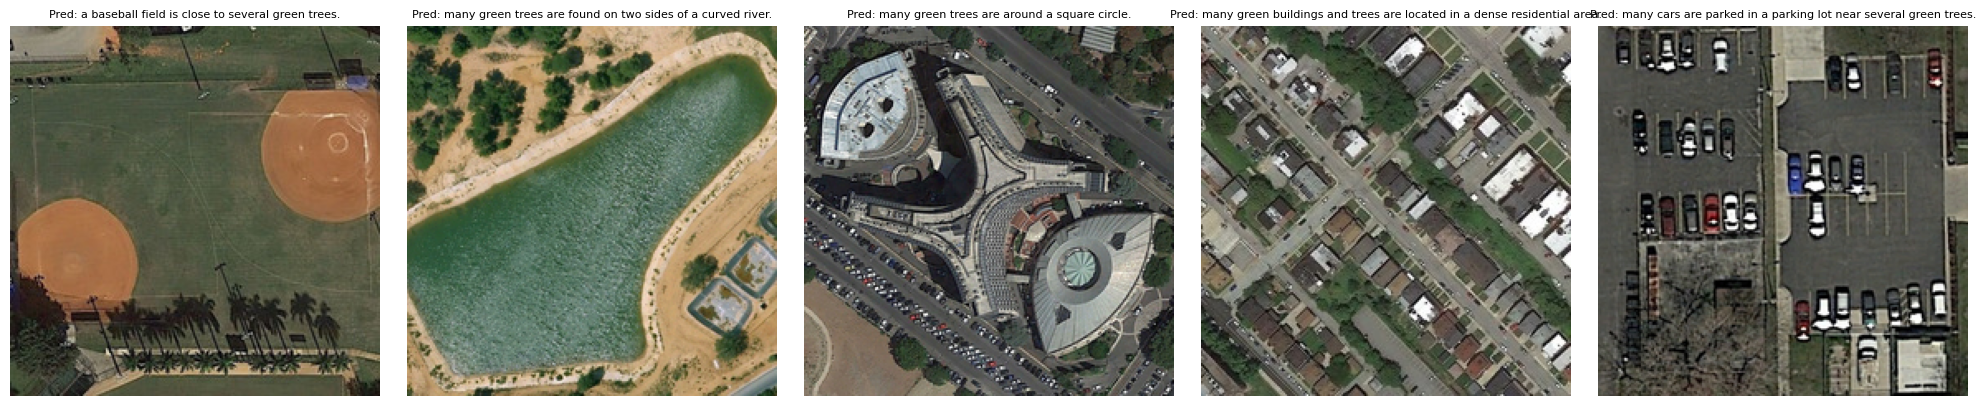


Saved predictions to 'test_predictions.json'


In [ ]:
import matplotlib.pyplot as plt

def visualize_predictions(refs, hyps, dataset, num_examples=5):
    indices = random.sample(range(len(refs)), min(num_examples, len(refs)))

    fig, axes = plt.subplots(1, num_examples, figsize=(4*num_examples, 4))
    if num_examples == 1:
        axes = [axes]

    for ax_idx, img_idx in enumerate(indices):
        ex = dataset.data[img_idx]
        img_path = ex.get("image_path", ex.get("image"))
        if isinstance(img_path, str):
            image = Image.open(img_path).convert("RGB")
        else:
            image = ex["image"]
            if not isinstance(image, Image.Image):
                image = Image.fromarray(np.array(image))

        axes[ax_idx].imshow(image)
        axes[ax_idx].axis('off')

        pred = hyps[img_idx][0]
        title = f"Pred: {pred}"
        axes[ax_idx].set_title(title, fontsize=8, wrap=True)

    plt.tight_layout()
    plt.savefig('test_predictions.png', dpi=150, bbox_inches='tight')
    print("\nSaved visualization to 'test_predictions.png'")
    plt.show()

print("\nVisualizing random examples...")
visualize_predictions(test_refs, test_hyps, test_data, num_examples=5)

import json

output_file = 'test_predictions.json'
predictions = []
for idx in range(len(test_refs)):
    predictions.append({
        'image_id': idx,
        'ground_truth': test_refs[idx],
        'prediction': test_hyps[idx][0]
    })

with open(output_file, 'w', encoding='utf-8') as f:
    json.dump({
        'metrics': {k: float(v) if v is not None else None for k, v in test_results.items()},
        'predictions': predictions[:100]  # Save first 100 examples
    }, f, indent=2, ensure_ascii=False)

print(f"\nSaved predictions to '{output_file}'")